# CausalNex tutorial

CausalNex is a library for causal structure learning and causal inference. 

## Important!

- Bayesian Networks in CausalNex support only discrete distributions.  Any continuous features, or features with a large number of categories, should be discretised prior to fitting the Bayesian Network. 
- The tutorial suggests reducing the cardinality of categorical variables through coarsening of the domain. The motivation for this is unclear/questionable.

## About this tutorial

This tutorial explores a tabular dataset consisting of student achievement in secondary education of two Portuguese schools. There are three variables relating to grade:

- G1: first period grade (numeric: from 0 to 20)
- G2: second period grade (numeric: from 0 to 20)
- G3: final grade (numeric: from 0 to 20)

Data are available from the [UCI ML repository](https://archive.ics.uci.edu/ml/datasets/Student+Performance)



In [1]:
import causalnex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image
from pathlib import Path
from sklearn.preprocessing import LabelEncoder

from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
data_dir = Path('./data/student')
data_file = 'student-por.csv'  # Portugese language course

In [4]:
data = pd.read_csv(data_dir/data_file, sep=';')

In [5]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [6]:
data.shape

(649, 33)

## Learning causal structure from data

CausalNex uses the [NOTEARS](https://arxiv.org/abs/1803.01422) algorithm to infer causal structure from data.

In [7]:
def visualize_structure(sm):
    viz = plot_structure(
        sm,
        graph_attributes={"scale": "0.5"},
        all_node_attributes=NODE_STYLE.WEAK,
        all_edge_attributes=EDGE_STYLE.WEAK)    
    return viz

The tutorial suggests dropping "sensitive" features such as sex which we "do not want" to include in our model. Going with the flow here...

In [8]:
drop_col = ['school','sex','age','Mjob', 'Fjob','reason','guardian']
data = data.drop(columns=drop_col)

Next we need to encode categorical variables with numeric values so that they can be parsed by NOTEARS.

In [9]:
struct_data = data.copy()

non_numeric_columns = list(struct_data.select_dtypes(
    exclude=[np.number]).columns)
print(non_numeric_columns)

['address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [10]:
le = LabelEncoder()
for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data.head()

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,0,4,4,2,2,0,1,0,...,4,3,4,1,1,3,4,0,11,11
1,1,0,1,1,1,1,2,0,0,1,...,5,3,3,1,1,3,2,9,11,11
2,1,1,1,1,1,1,2,0,1,0,...,4,3,2,2,3,3,6,12,13,12
3,1,0,1,4,2,1,3,0,0,1,...,3,2,2,1,1,5,0,14,14,14
4,1,0,1,3,3,1,2,0,0,1,...,4,3,2,1,2,5,0,11,13,13


We now apply the NOTEARS algorithm to learn causal structure from the observational data

In [11]:
sm = from_pandas(struct_data)

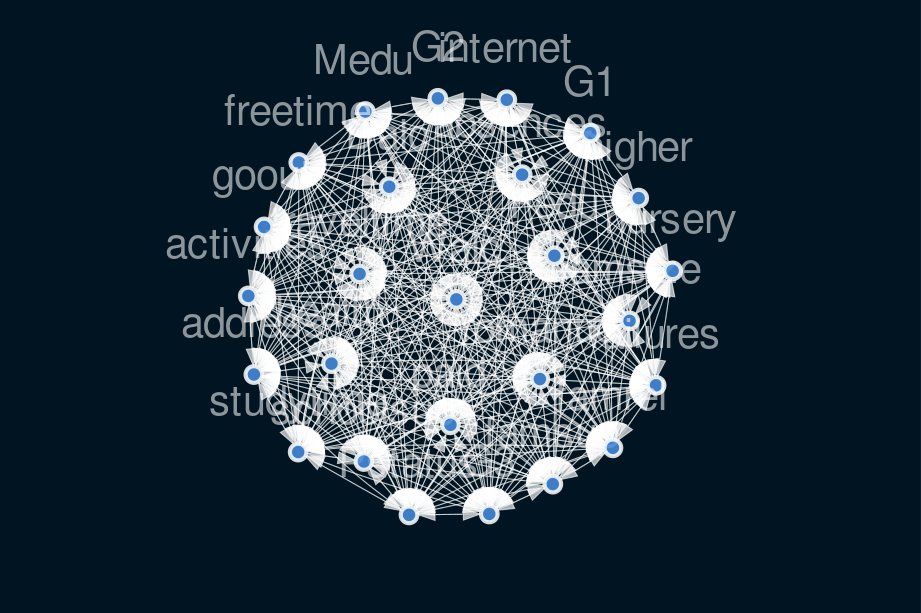

In [12]:
viz = visualize_structure(sm)
Image(viz.draw(format='png'))

In [13]:
('famsize', 'address') in sm.edges

True

In [14]:
('address', 'famsize') in sm.edges

True

A fully-connected graph has been learnt. **Q**: this doesn't seem to be a DAG. Why? Isn't NOTEARS supposed to find DAGs?

The tutorial suggests removing weaker edges

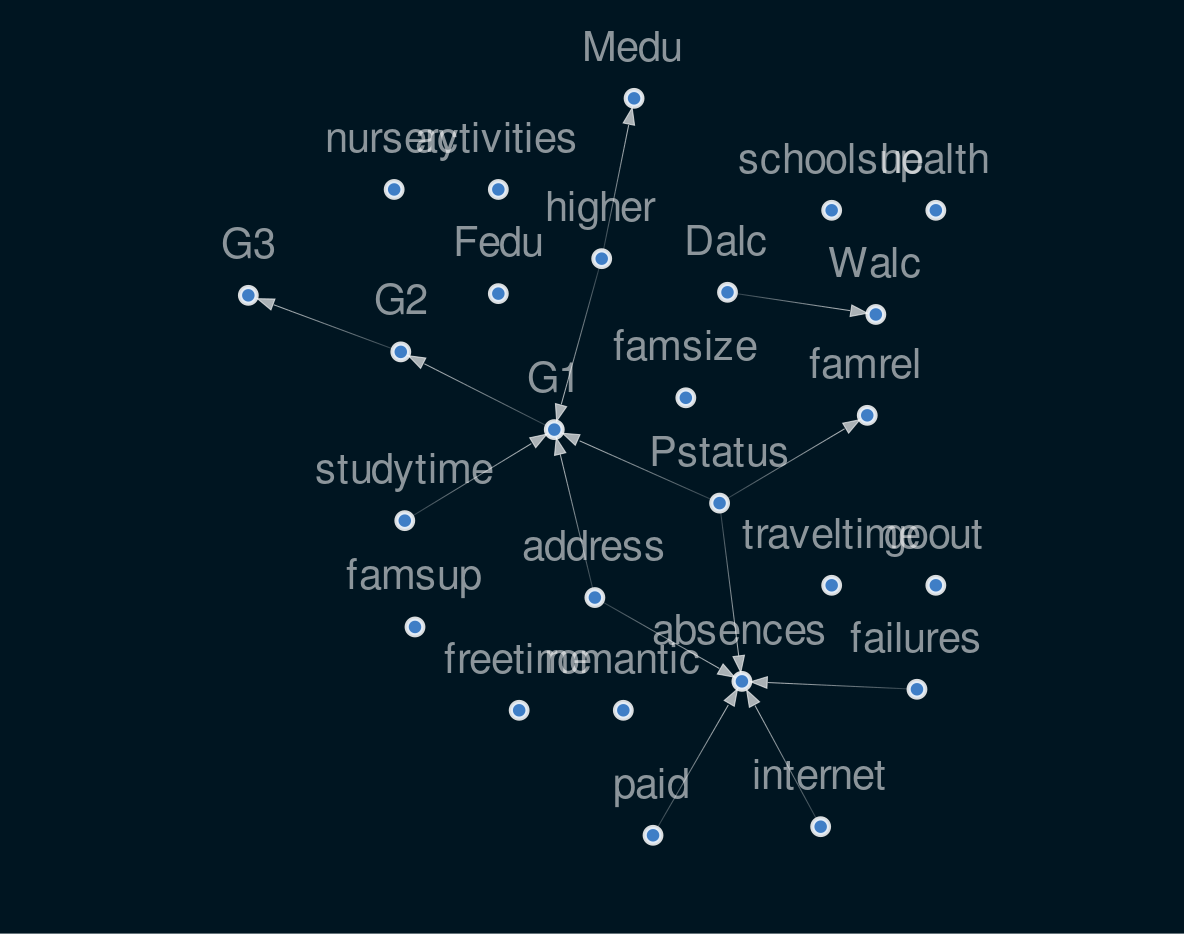

In [15]:
sm.remove_edges_below_threshold(0.8)
viz = visualize_structure(sm)
Image(viz.draw(format='png'))

Some edges here are definitely incorrect. 

- higher: wants to take higher education (binary: yes or no)
- Medu: mother's education

An edge (`higher`, `Medu`) doesn't make much sense.

We can manually forbid certain edges during structure learning.

In [16]:
sm = from_pandas(struct_data, 
                 tabu_edges=[("higher", "Medu")], w_threshold=0.8)

And manually add/remove edges

In [17]:
sm.add_edge("failures", "G1")
sm.remove_edge("Pstatus", "G1")
sm.remove_edge("address", "G1")

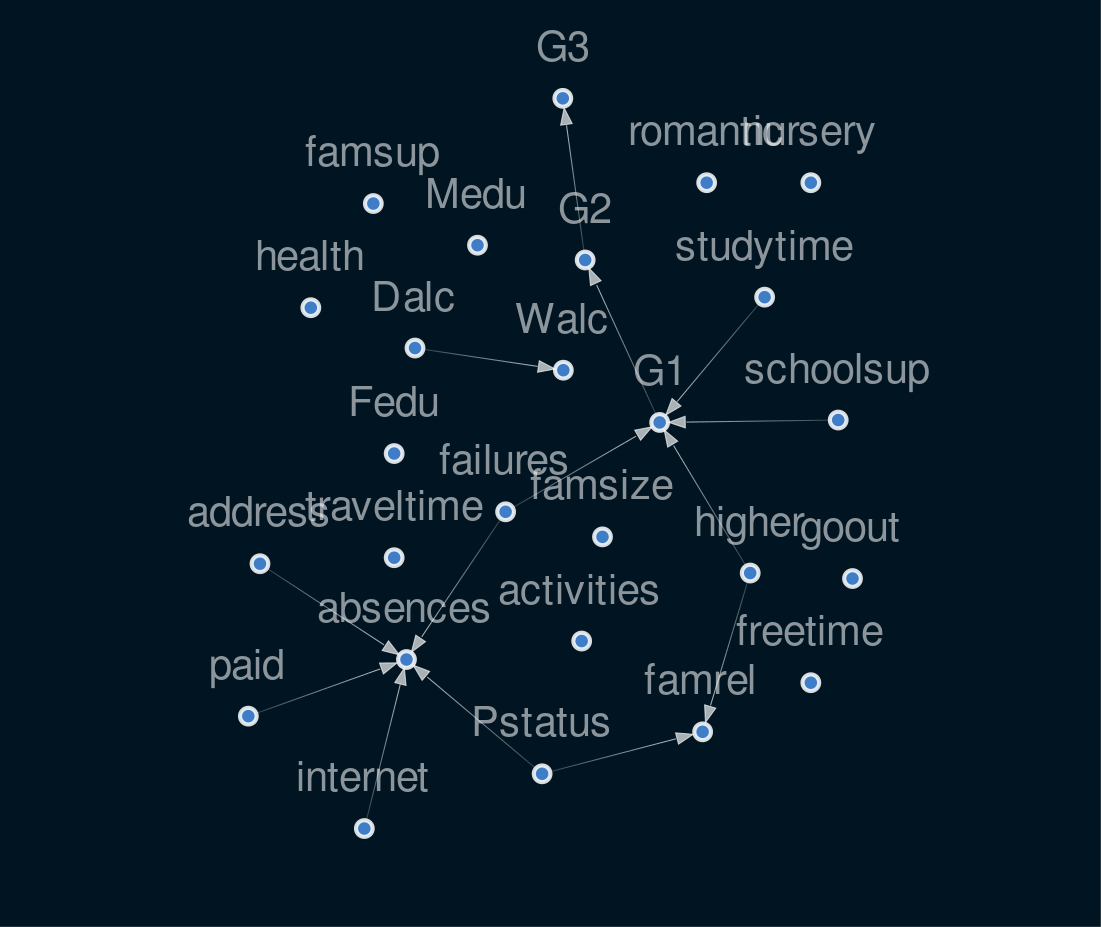

In [18]:
viz = visualize_structure(sm)
Image(viz.draw(format='png'))

We can get the largest subgraph like so:

In [19]:
sm = sm.get_largest_subgraph()

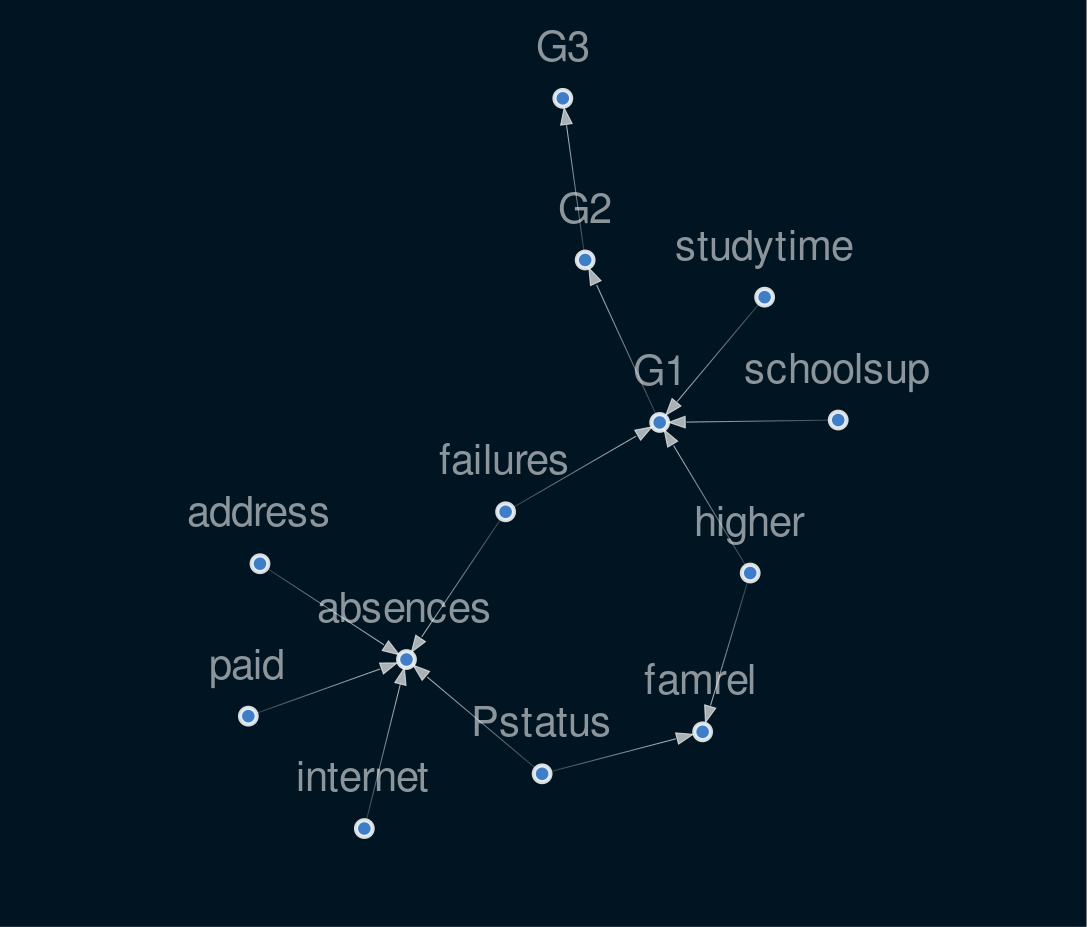

In [20]:
viz = visualize_structure(sm)
Image(viz.draw(format='png'))

From the causal structure, we now instantiate a `BayesianNetwork`.

In [21]:
from causalnex.network import BayesianNetwork

In [22]:
bn = BayesianNetwork(sm)

## Data coarsening 

The tutorial here suggests coarsening the state space of the model. This is likely due to some kind of methodological fragility. My intuition says that this is not ideal as it's losing information.

Let's proceed and see where this ends up.

In [23]:
coarsened_data = struct_data.copy()

data_vals = {col: data[col].unique() for col in data.columns}

failures_map = {v: 'no-failure' if v == 0
               else 'have-failure' for v in data_vals['failures']}

studytime_map = {v: 'short-studytime' if v in [1,2]
                 else 'long-studytime' for v in data_vals['studytime']}

In [24]:
coarsened_data['failures'] = coarsened_data['failures'].map(failures_map)
coarsened_data['studytime'] = coarsened_data['studytime'].map(studytime_map)

They now suggest discretization of numerical features

In [25]:
from causalnex.discretiser import Discretiser

In [26]:
coarsened_data["absences"] = Discretiser(
    method="fixed",
    numeric_split_points=[1, 10]).transform(coarsened_data["absences"].values)

coarsened_data["G1"] = Discretiser(
    method="fixed",
    numeric_split_points=[10]).transform(coarsened_data["G1"].values)

coarsened_data["G2"] = Discretiser(
    method="fixed",
    numeric_split_points=[10]).transform(coarsened_data["G2"].values)

coarsened_data["G3"] = Discretiser(
    method="fixed",
    numeric_split_points=[10]).transform(coarsened_data["G3"].values)

In [27]:
absences_map = {0: "No-absence", 1: "Low-absence", 2: "High-absence"}

G1_map = {0: "Fail", 1: "Pass"}
G2_map = {0: "Fail", 1: "Pass"}
G3_map = {0: "Fail", 1: "Pass"}

coarsened_data["absences"] = coarsened_data["absences"].map(absences_map)
coarsened_data["G1"] = coarsened_data["G1"].map(G1_map)
coarsened_data["G2"] = coarsened_data["G2"].map(G2_map)
coarsened_data["G3"] = coarsened_data["G3"].map(G3_map)

So we started out with e.g. this:

In [28]:
data[['absences', 'G1', 'G2', 'G3']]

,absences,G1,G2,G3
0,4,0,11,11
1,2,9,11,11
2,6,12,13,12
3,0,14,14,14
4,0,11,13,13
...,...,...,...,...
644,4,10,11,10
645,4,15,15,16
646,6,11,12,9
647,6,10,10,10


And coarsened to a binary outcome (in a rather long-winded way)

In [29]:
coarsened_data[['absences', 'G1', 'G2', 'G3']]

,absences,G1,G2,G3
0,Low-absence,Fail,Pass,Pass
1,Low-absence,Fail,Pass,Pass
2,Low-absence,Pass,Pass,Pass
3,No-absence,Pass,Pass,Pass
4,No-absence,Pass,Pass,Pass
...,...,...,...,...
644,Low-absence,Pass,Pass,Pass
645,Low-absence,Pass,Pass,Pass
646,Low-absence,Pass,Pass,Fail
647,Low-absence,Pass,Pass,Pass


Now form a test/train split

In [30]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(coarsened_data, 
                               train_size=0.8, 
                               test_size=0.2, 
                               random_state=101,
                              )

## Fit a mutually dependent categorical model with Dirichlet priors

CausalNex uses `pgmpy` to build [conditional probability distribution tables](https://en.wikipedia.org/wiki/Conditional_probability_table), with Dirichlet priors. TODO: Find out the explicit likelihood. Is the likelihood built empirically from observations, or is there a more interpretable model lurking in there somewhere? 

Determine the distinct values of all features

In [31]:
bn = bn.fit_node_states(coarsened_data)

In [32]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

Now, recall that there are 4 parent nodes of `G1`:

- `failures`: number of past class failures
- `higher`: wants to take higher education
- `schoolsup`: extra educational support
- `studytime`: weekly study time


Each column below is (I think??)

$$P(G_1 | fi, hi, sch, stu)$$

which is the causal effect on the response given each level of the input.

In [33]:
bn.cpds['G1']

failures    have-failure                                                 \
higher                 0                                                  
schoolsup              0                              1                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
Fail                0.75            0.84            0.5            0.75   
Pass                0.25            0.16            0.5            0.25   

failures                                                                 \
higher                 1                                                  
schoolsup              0                              1                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
Fail            0.444444        0.622222            0.5            0.75   
Pass            0.555556        0.377778            0.5            0.25   

failures      no-failure                                                 \
higher                 0                                                  
schoolsup              0                              1                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
Fail                 0.6        0.708333            0.5             0.5   
Pass                 0.4        0.291667            0.5             0.5   

failures                                                                 
higher                 1                                                 
schoolsup              0                              1                  
studytime long-studytime short-studytime long-studytime short-studytime  
G1                                                                       
Fail            0.035294        0.152778       0.153846        0.242424  
Pass            0.964706        0.847222       0.846154        0.757576

## Predictions

In [40]:
predictions = bn.predict(test, 'G1')
predictions = pd.merge(test['G1'], predictions, left_index=True, right_index=True)

Accuracy:

In [44]:
(predictions['G1'] == predictions['G1_prediction']).sum()/predictions.shape[0]

0.8153846153846154

Not too bad.

## Model quality

In [45]:
from causalnex.evaluation import classification_report

In [46]:
classification_report(bn, test, "G1")

{'G1_Fail': {'precision': 0.5555555555555556,
  'recall': 0.5555555555555556,
  'f1-score': 0.5555555555555556,
  'support': 27},
 'G1_Pass': {'precision': 0.883495145631068,
  'recall': 0.883495145631068,
  'f1-score': 0.883495145631068,
  'support': 103},
 'accuracy': 0.8153846153846154,
 'macro avg': {'precision': 0.7195253505933118,
  'recall': 0.7195253505933118,
  'f1-score': 0.7195253505933118,
  'support': 130},
 'weighted avg': {'precision': 0.8153846153846154,
  'recall': 0.8153846153846154,
  'f1-score': 0.8153846153846154,
  'support': 130}}

In [51]:
from causalnex.evaluation import roc_auc
roc, auc = roc_auc(bn, test, "G1")
print(auc)

0.8928402366863906


## Querying marginals

In [52]:
from causalnex.inference import InferenceEngine

In [53]:
ie = InferenceEngine(bn)
marginals = ie.query()
marginals["G1"]  # P(G1|data)

{'Fail': 0.26067152566227375, 'Pass': 0.7393284743377261}

We can also get `P(G1|studytime=short, data)`

In [54]:
marginals_short = ie.query({"studytime": "short-studytime"})
marginals_short['G1']

{'Fail': 0.2859794642967034, 'Pass': 0.7140205357032966}

## Do Calculus

We can perform simple interventions with `do_intervention`

If everyone wanted to do higher education, what would be the impact on `G1`?

In [56]:
ie.do_intervention("higher", {1:1.0, 0:0.0})

In [58]:
ie.query()['G1']

{'Fail': 0.2119714714219339, 'Pass': 0.788028528578066}

Reset the intervention

In [59]:
ie.reset_do("higher")

In [60]:
ie.query()['G1']

{'Fail': 0.26067152566227375, 'Pass': 0.7393284743377261}